In [2]:
import numpy as np
import sys
from scipy.linalg import expm
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
from IPython.display import display


In [3]:
def create_double_hopping_fermionic_operator(i, j, k, m, N):
    if i > j or j > k or k > m:
        raise ValueError("please order your index")
    else:
        L = 2**N
        H = np.zeros((L,L))
        if i!=j:
            for num in range(L):
                state = list(np.binary_repr(num, N))
                if state[i] == "0" and state[j] == "0" and state[k] == "1" and state[m] == "1":
                    counter = -1
                    for l in range(i, j):
                        cur_str = state[l]
                        if cur_str == "1":
                            counter *= -1
                    for l in range(k,m):
                        cur_str = state[l]
                        if cur_str == "1":
                            counter *= -1
                    new_state = state.copy()
                    new_state[i] = "1"
                    new_state[j] = "1"
                    new_state[k] = "0"
                    new_state[m] = "0"
                    new_state = "".join(new_state)
                    new_state = int(new_state, 2)
                    H[new_state, num] = counter
        else:
            for k in range(L):
                state = list(np.binary_repr(k, N))
                if state[i] == "1":
                    H[k, k] = 1
    H = H - H.transpose()
    return H

In [4]:
i = 0
j = 1
k = 3
m = 5
N = 7
t = 1
ops = FermionicOp({"+_" + str(i)+" +_"+str(j)+ " -_" + str(k)+" -_"+str(m) : t,\
                    "+_" + str(m)+" +_"+str(k)+ " -_" + str(j)+" -_"+str(i):-t}, num_spin_orbitals=N)
mapper = JordanWignerMapper()
jw_op = mapper.map(ops)
jw_op = qi.Operator(jw_op).to_matrix()
jw_op = np.array(jw_op)

H = create_double_hopping_fermionic_operator(i, j, k, m, N)
print(ops)
eigH = np.linalg.eig(H)[0]
eigJW = np.linalg.eig(jw_op)[0]
eigH = np.sort(1j*eigH)
eigJW = np.sort(1j*eigJW)
print(f"i = {i}, j = {j}, k = {k}, m = {m}, N = {N}")
print(f"The norm of the eigenvalue of qubit matrix is {np.linalg.norm(eigH)}")
print(f"The norm of the eigenvalue of the JW transformation from Qiskit is {np.linalg.norm(eigJW)}")
print(f"The difference between two eigenvalue vector is {np.sum(abs(eigH - eigJW))}")

Fermionic Operator
number spin orbitals=7, number terms=2
  1 * ( +_0 +_1 -_3 -_5 )
+ -1 * ( +_5 +_3 -_1 -_0 )
i = 0, j = 1, k = 3, m = 5, N = 7
The norm of the eigenvalue of qubit matrix is 4.0
The norm of the eigenvalue of the JW transformation from Qiskit is 3.999999999999999
The difference between two eigenvalue vector is 2.886579864025407e-15


In [92]:
def create_ladder_cnot(qc,i,j,k,m,t,N):
    for a in range(i,j):
        qc.cx(N-a-1, N - a - 2)
    
    qc.cx(N - j - 1, N - k - 1)
    
    for b in range(k, m):
        qc.cx(N-b-1, N-b-2)
    
    qc.rz(t, N-m-1)
    
    for b in range(m, k,-1):
        qc.cx(N-b, N-b-1)

    qc.cx(N - j - 1, N - k - 1)

    for a in range(j,i,-1):
        qc.cx(N-a, N - a - 1)
    return None

    

In [6]:
def create_circuit_components(qc, i, j, k, m, t, N, gate_sets):
    index = [i,j,k,m]
    
    for a in range(4):
        cur_index = index[a]
        if gate_sets[a] == "X":
            qc.h(N-cur_index-1)
        else:
            qc.sdg(N-cur_index-1)
            qc.h(N-cur_index-1)
    
    create_ladder_cnot(qc, i, j, k, m, t, N)
    
    for a in range(4):
        cur_index = index[a]
        if gate_sets[a] == "X":
            qc.h(N-cur_index-1)
        else:
            qc.h(N-cur_index-1)
            qc.s(N-cur_index-1)
    return None
            


In [7]:
def create_double_hopping_qubit_exponent(i, j, k, m, t, N, gate_sets):
    # This is a test function
    y = np.array([[0, -1j], [1j, 0]])
    x = np.array([[0, 1], [1, 0]])
    z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    M = 1
    for a in range(N):
        if a < i:
            M = np.kron(M, I)
        elif a == i:
            if gate_sets[0] == "X":
                M = np.kron(M, x)
            else:
                M = np.kron(M, y)
        elif a < j:
            M = np.kron(M, z)
        elif a == j:
            if gate_sets[1] == "X":
                M = np.kron(M, x)
            else:
                M = np.kron(M, y)
        elif a < k:
            M = np.kron(M, I)
        elif a == k:
            if gate_sets[2] == "X":
                M = np.kron(M, x)
            else:
                M = np.kron(M, y)
        elif a < m:
            M = np.kron(M, z)
        elif a == m:
            if gate_sets[3] == "X":
                M = np.kron(M, x)
            else:
                M = np.kron(M, y)
        else:
            M = np.kron(M, I)
    M = expm(-1j*t*M/2)
    return M

In [70]:
def create_double_hopping_circuit(i,j,k,m,t,N):
    qc = QuantumCircuit(N)
    create_circuit_components(qc, i, j, k, m, -t/4, N, ["X","X","X","Y"])
    create_circuit_components(qc, i, j, k, m, -t/4, N, ["X","X","Y","X"])
    create_circuit_components(qc, i, j, k, m, t/4, N, ["X","Y","X","X"])
    create_circuit_components(qc, i, j, k, m, -t/4, N, ["X","Y","Y","Y"])
    create_circuit_components(qc, i, j, k, m, t/4, N, ["Y","X","X","X"])
    create_circuit_components(qc, i, j, k, m, -t/4, N, ["Y","X","Y","Y"])
    create_circuit_components(qc, i, j, k, m, t/4, N, ["Y","Y","X","Y"])
    create_circuit_components(qc, i, j, k, m, t/4, N, ["Y","Y","Y","X"])
    return qc
    

In [48]:
def create_cubit_doublt_hopping_matrix(i,j,k,m,N):
    y = np.array([[0, -1j], [1j, 0]])
    x = np.array([[0, 1], [1, 0]])
    z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    A = 1
    B = 1
    Qp = (x-1j*y)/2
    Qm = (x+1j*y)/2
    for a in range(N):
        if a < i:
            A = np.kron(A, I)
            B = np.kron(B, I)
        elif a == i:
            A = np.kron(A, Qp)
            B = np.kron(B, Qm)
        elif a < j:
            A = np.kron(A,z)
            B = np.kron(B,z)
        elif a == j:
            A = np.kron(A, Qp)
            B = np.kron(B, Qm)
        elif a < k:
            A = np.kron(A, I)
            B = np.kron(B, I)
        elif a == k:
            A = np.kron(A, Qm)
            B = np.kron(B, Qp)
        elif a < m:
            A = np.kron(A,z)
            B = np.kron(B,z)
        elif a == m:
            A = np.kron(A, Qm)
            B = np.kron(B, Qp)
        else:
            A = np.kron(A, I)
            B = np.kron(B, I)
    return A-B


In [76]:
N = 7
i = 0
j = 1
k = 4
m = 6
t = 1
H = create_double_hopping_fermionic_operator(i, j, k, m, N)
M = create_cubit_doublt_hopping_matrix(i,j,k,m,N)
# print(H)
print(np.sum(abs(H-M)))

0.0


In [95]:
N = 10
i = 0
j = 3
k = 6
m = 9
t = 10
qc = QuantumCircuit(N)
gate_set = ["Y", "X", "Y", "Y"]
create_circuit_components(qc,i,j,k,m,t,N, gate_set)
M = create_double_hopping_qubit_exponent(i, j, k, m, t, N, gate_set)
# print(M)
m = qi.Operator(qc).to_matrix()
m = np.array(m)
print(np.sum(abs(m-M)))

4.547473508864641e-13


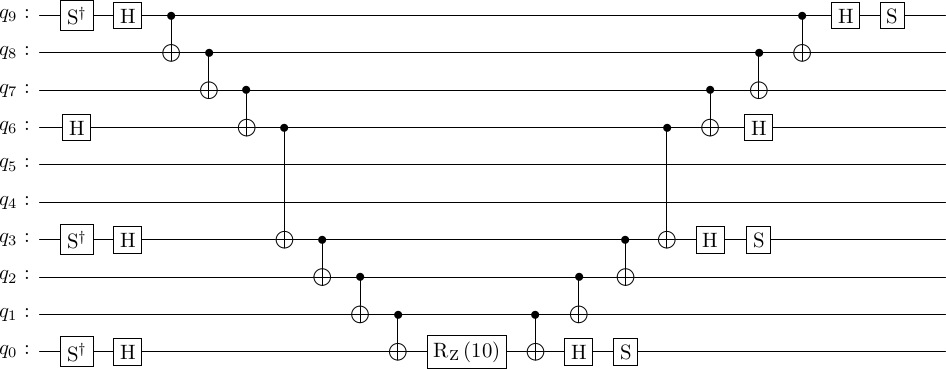

In [96]:
display(qc.draw("latex", reverse_bits=True))

In [98]:
N = 10
i = 0
j = 3
k = 6
m = 9
t = 10
qc = create_double_hopping_circuit(i,j,k,m,t,N)
M = qi.Operator(qc).to_matrix()
M = np.array(M)
H = create_double_hopping_fermionic_operator(i, j, k, m, N)
expH = expm(t*H)
# print(expH)
print(np.sum(M-expH))

(-4.419575816427823e-12+0j)


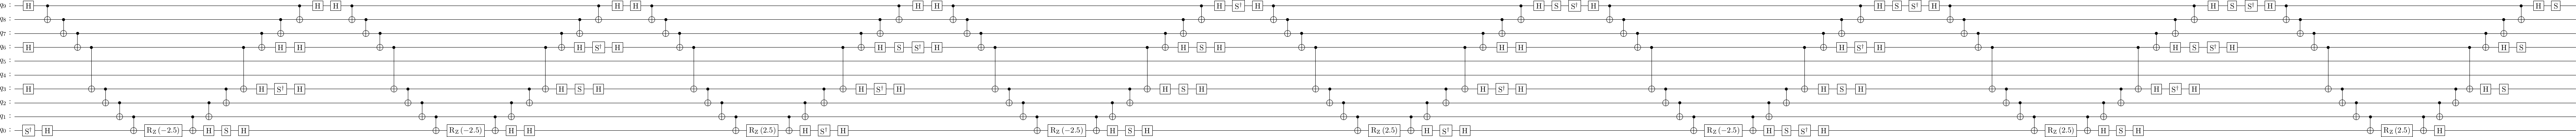

In [99]:
display(qc.draw("latex", reverse_bits=True))

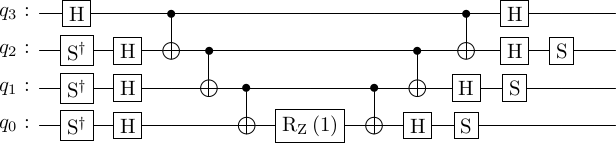

In [10]:
display(qc.draw("latex", reverse_bits=True))